# Forecasting Stock Prices
**Data Analytics and Big Data Capstone Project 2018c-5 - Data Science with Python**

### 3. Time Series Decomposition

In [2]:
# Load libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns; sns.set()

from matplotlib.pyplot import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

# plot within notebook
%matplotlib inline

warnings.filterwarnings('ignore')

In [3]:
## load parameters

# set figure size
rcParams['figure.figsize'] = 15, 8

In [4]:
# Load dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# load data
df_adj = pd.read_csv('.\\data\\eod.data-intc-adjusted.lv1.csv')

In [5]:
# setting the index as date
df_adj['date'] = pd.to_datetime(df_adj.date, format='%Y-%m-%d')
df_adj.index = df_adj['date']
df_adj.drop(['date'], axis=1, inplace=True)
df_adj.sort_index(ascending=True, axis=0, inplace=True)
df_adj.head(5)

,close
date,
2018-01-31,48.14
2018-02-01,47.65
2018-02-02,46.15
2018-02-05,44.52
2018-02-06,44.91


In [6]:
df_adj.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 538 entries, 2018-01-31 to 2020-03-20
Data columns (total 1 columns):
close    538 non-null float64
dtypes: float64(1)
memory usage: 8.4 KB


#### 3.1 preliminary seasonal decompose

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_adj, model='multiplicative', period=12)

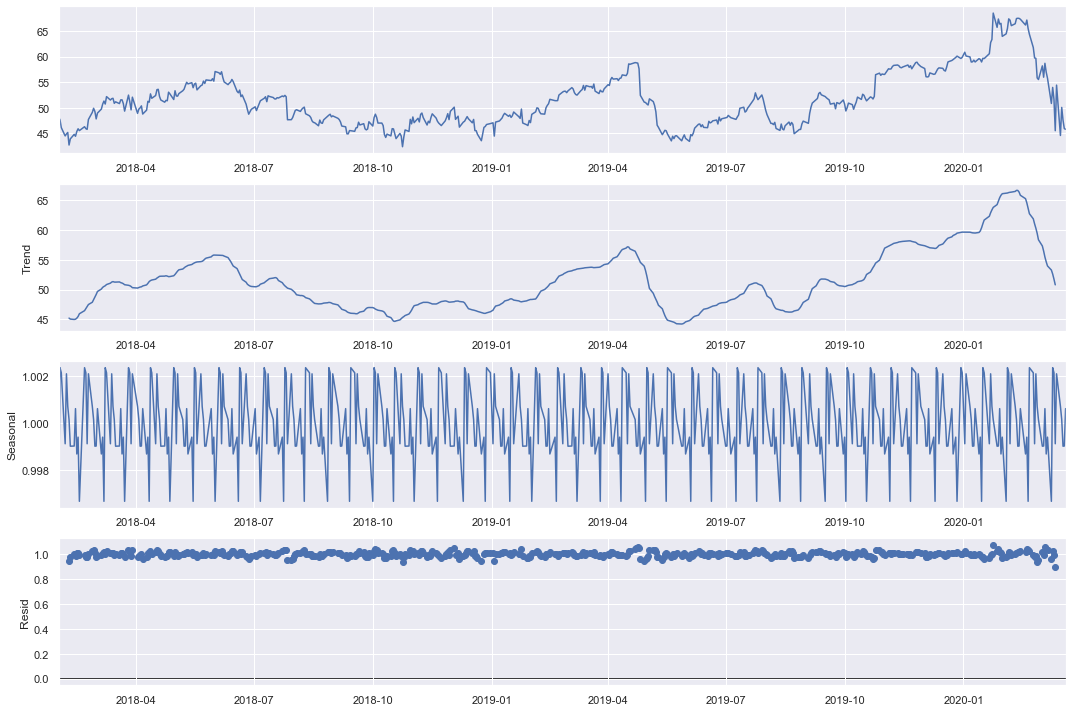

In [11]:
# plot seasonal decompose
rcParams['figure.figsize'] = 15, 10
result.plot()

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Decompose_Full_lv1.jpg')

The 'Seasonal Decomposition' diagram does not show a clear trend in the data. In addition, we can also observe that the 'Residual' diagram shows an average line (below in black) around 0.0, very far from the data (above) around 1.0.
The visual analysis year after year does not allow observing relationships, as evidenced in the previous stage (EDA).

#### 3.2 Stationarising the Time Series.

We need to check if a series is stationary or not. For this purpose we will use the ADF (Augmented Dickey-Fuller) Test, which is used to determine the presence of 'unit root' in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:
- **Null Hypothesis**: The series `has a unit root` (value of a =1)
- **Alternate Hypothesis**: The series `has no unit root`.

In [27]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    rcParams['figure.figsize'] = 10, 5
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    #perform dickey fuller test
    print("Results of dickey fuller test\n")

    adft = adfuller(timeseries['close'], autolag='AIC')

    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    
    output = pd.Series(adft[0:4],index=['Test Statistics',
                                        'pvalue',
                                        'No. of lags used',
                                        'Number of observations used'])

    for key,values in adft[4].items():
        output['critical value (%s)'%key] = values
    
    print(output)

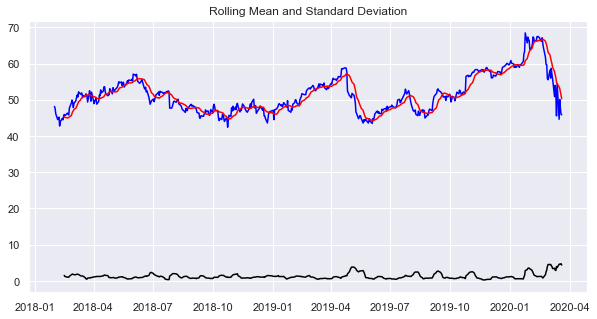

Results of dickey fuller test

Test Statistics                 -3.017741
pvalue                           0.033270
No. of lags used                10.000000
Number of observations used    527.000000
critical value (1%)             -3.442820
critical value (5%)             -2.867040
critical value (10%)            -2.569699
dtype: float64


<Figure size 720x360 with 0 Axes>

In [28]:
test_stationarity(df_adj)
plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Stationarising_Full_lv1.jpg')

Through the above graph, we can see the highly variable mean (red line) and standard deviation (black line) and hence our series is not stationary.

We see that the p-value is greater than 0.03 (0.033270) so **we cannot reject the Null hypothesis**. Also, the test statistics (-3.017741) is less than the critical values (-3.442820). So the data is non-stationary.

To get a stationary series, we need to eliminate the trend and seasonality from the series.

We start by taking a log of the series to reduce the magnitude of the values and reduce the trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean for 'Close Price' value at every point further ahead in series.

#### 3.3 Moving Average

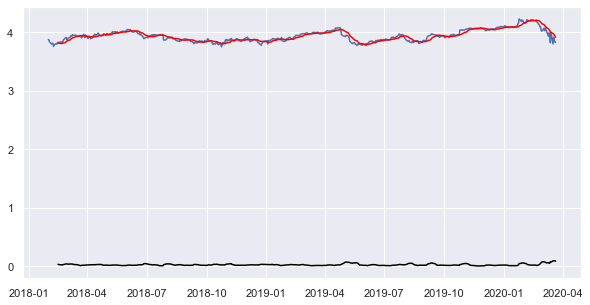

<Figure size 720x360 with 0 Axes>

In [29]:
# reduce the magnitude of the values and reduce the trend in the series
df_log = np.log(df_adj)

# get rolling average
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

rcParams['figure.figsize'] = 10, 5
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Moving_Average_Full_lv1.jpg')

After finding the mean, we take the difference of the series and the mean at every point in the series.

This way, we eliminate trends out of a series and obtain a more stationary series.

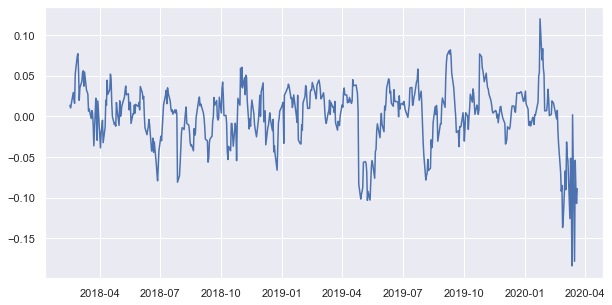

<Figure size 720x360 with 0 Axes>

In [30]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

rcParams['figure.figsize'] = 10, 5
plt.plot(df_log_moving_avg_diff)
plt.show()

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Moving_Average_Diff_lv1.jpg')

Perform the Dickey-Fuller Test (ADFT) once again. We have to perform this function every time to check whether the data is stationary or not.

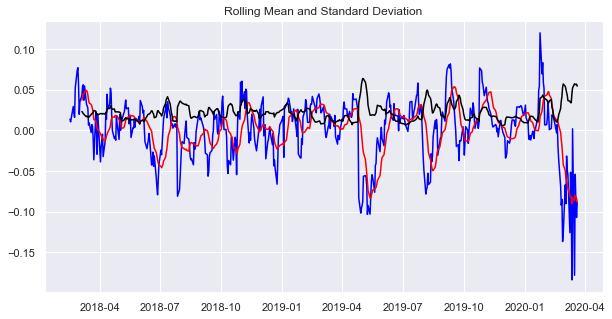

Results of dickey fuller test

Test Statistics                 -4.915020
pvalue                           0.000033
No. of lags used                10.000000
Number of observations used    516.000000
critical value (1%)             -3.443087
critical value (5%)             -2.867158
critical value (10%)            -2.569762
dtype: float64


<Figure size 720x360 with 0 Axes>

In [32]:
test_stationarity(df_log_moving_avg_diff)
plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Moving_Average_Diff_ADFT_lv1.jpg')

In the graph above, we note that the data **did not attained stationarity**.

One of the modules is completed as we came to a conclusion. We need to check the weighted average, to understand the trend of the data in time series. 

In [35]:
weighted_average = df_log.ewm(halflife=12,
                              min_periods=0,
                              adjust=True).mean()
weighted_average

,close
date,
2018-01-31,3.874113
2018-02-01,3.868850
2018-02-02,3.855815
2018-02-05,3.839525
2018-02-06,3.831724
...,...
2020-03-16,4.052632
2020-03-17,4.044830
2020-03-18,4.034627


The 'Exponential Moving Average' (EMA) **is a weighted average of the last n prices, where the weighting decreases exponentially with each previous price/period**. In other words, the formula gives recent prices more weight than past prices.

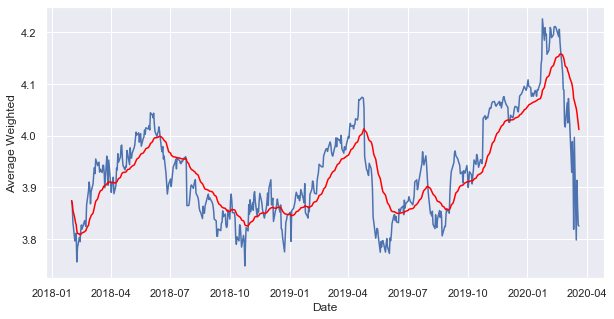

<Figure size 720x360 with 0 Axes>

In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

plt.plot(df_log)
plt.plot(weighted_average, color='red')
plt.xlabel("Date")
plt.ylabel("Average Weighted")

#plt.legend()
plt.show(block =False)
plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Moving_Average_Weighted_lv1.jpg')

Using the moving average data in (df_log), we will subtract the average weight (weighted_average) and perform the Dickey-Fuller (ADFT) test once again.

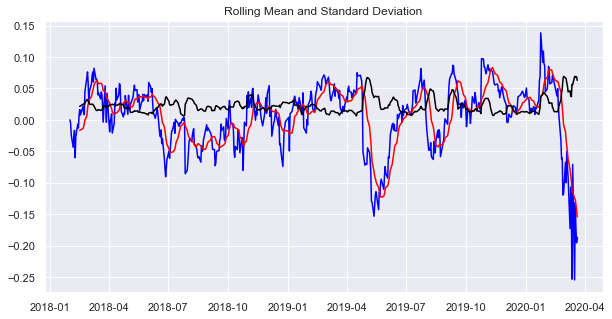

Results of dickey fuller test

Test Statistics                 -3.438950
pvalue                           0.009701
No. of lags used                10.000000
Number of observations used    527.000000
critical value (1%)             -3.442820
critical value (5%)             -2.867040
critical value (10%)            -2.569699
dtype: float64


<Figure size 720x360 with 0 Axes>

In [38]:
rcParams['figure.figsize'] = 10,5
logScale_weightedMean = df_log-weighted_average
test_stationarity(logScale_weightedMean)
plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Moving_Average_Weighted_Log_lv1.jpg')

From the above graph, we observed that the data **not attained stationarity**. We also see that the test statistics (Test Statistics -3.438950) and critical value (critical value (1%) -3.442820) is relatively equal.

There can be cases when there is a high seasonality in the data. In those cases, just removing the trend will not help much. We need to also remove the seasonality in the series. One such method for this task is differencing.

#### 3.4 Removing Trend and Seasonality (Differencing Technique)

Differencing is a method of transforming a time series dataset. It can be used to remove the series dependence on time, so-called 'temporal dependence'. This includes structures like trends and seasonality. Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality. Differencing is performed by subtracting the previous observation from the current observation.

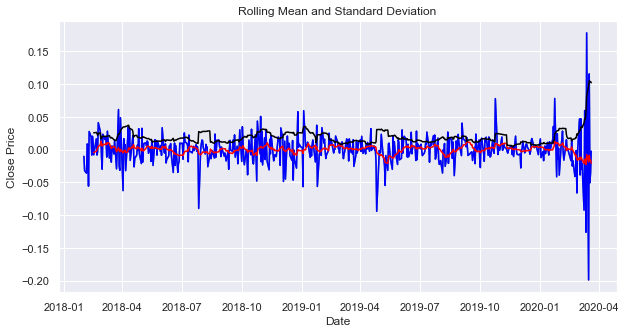

Results of dickey fuller test

Test Statistics                 -5.562146
pvalue                           0.000002
No. of lags used                 9.000000
Number of observations used    527.000000
critical value (1%)             -3.442820
critical value (5%)             -2.867040
critical value (10%)            -2.569699
dtype: float64


<Figure size 720x360 with 0 Axes>

In [39]:
df_log_diff = df_log - df_log.shift()

plt.title("Shifted Time Series")
plt.xlabel("Date")
plt.ylabel("Close Price")
rcParams['figure.figsize'] = 10,5
plt.plot(df_log_diff)

# Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)

test_stationarity(df_log_diff)
plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Differencing_Technique_Full_lv1.jpg')

The next step is to perform decomposition which provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model. Finally, perform the Dickey-Fuller test (ADFT) once again.

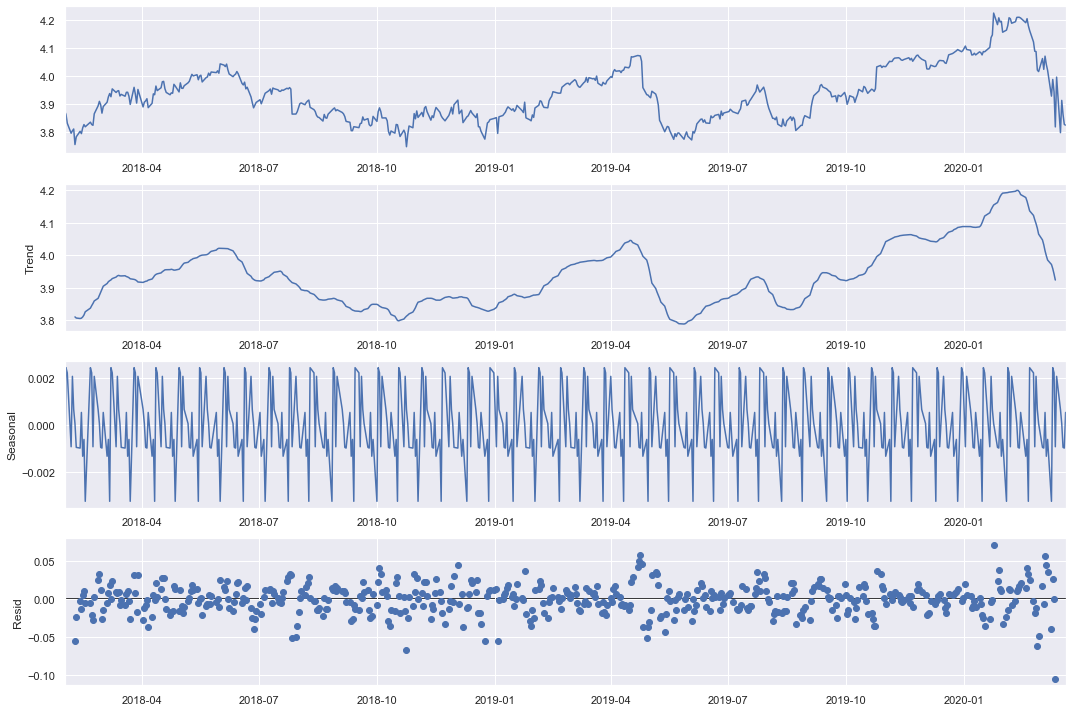

In [44]:
result = seasonal_decompose(df_log, model='additive', freq = 12)

rcParams['figure.figsize'] = 15,10
result.plot()

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Differencing_Tech_SeaDeco_Full_lv1.jpg')

Notice how the values show a behavior around the mean and standard deviation (superimposed on the Resid's black line)

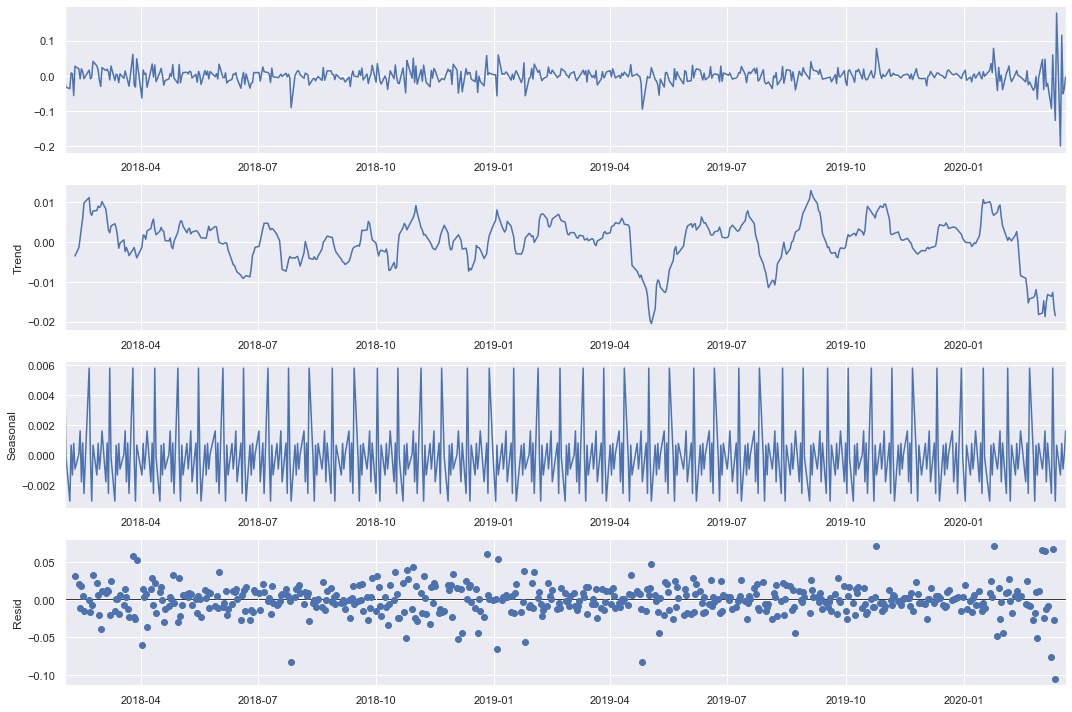

In [46]:
resultB = seasonal_decompose(df_log_diff, model='additive', freq = 12)

rcParams['figure.figsize'] = 15,10
resultB.plot()

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Differencing_Tech_SeaDeco_Log_Diff_lv1.jpg')

The same observation as the previous one, although with some scattered values. Even the trend continues without showing clear evidence and the general values are concentrated around 0.0, with a clear bias at the end to the right.

After decomposition we can see in the residual (Resid) that we clearly have a flat line for the standard deviation and the mean into both grath. At this point we can ensure that our series is stationary and now we can move to find the best parameters for our model.

#### 3.5  Decomposition Details

The diagrams below show the seasonal components for 'df_log'.

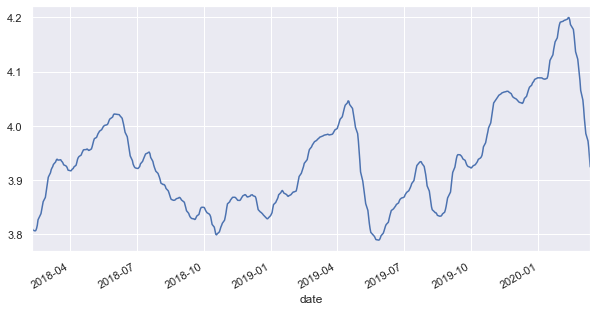

In [49]:
trend = result.trend
trend.dropna(inplace=True)

rcParams['figure.figsize'] = 10,5
trend.plot()

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Differencing_Decomposition_Details_Trend_lv1.jpg')

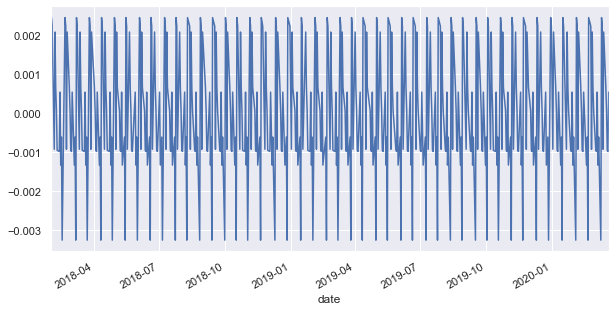

In [50]:
seasonality = result.seasonal
seasonality.dropna(inplace=True)

rcParams['figure.figsize'] = 10,5
seasonality.plot()

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Differencing_Decomposition_Details_season_lv1.jpg')

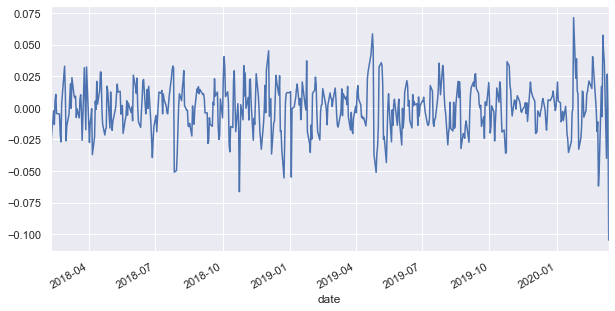

In [51]:
residual = result.resid
residual.dropna(inplace=True)

rcParams['figure.figsize'] = 10,5
residual.plot()

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Differencing_Decomposition_Details_resid_lv1.jpg')

In [64]:
residual.columns=['Date', 'Close']
residual.head(10)

date
2018-02-08   -0.055690
2018-02-09   -0.023513
2018-02-12   -0.002288
2018-02-13   -0.013092
2018-02-14    0.005546
2018-02-15    0.010660
2018-02-16   -0.004470
2018-02-20   -0.004876
2018-02-21   -0.020378
2018-02-22   -0.027010
Name: resid, dtype: float64

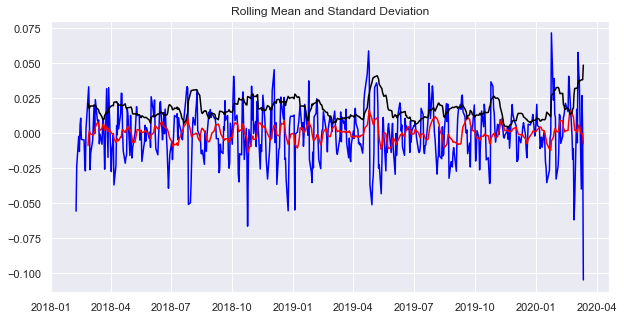

Results of dickey fuller test



KeyError: 'close'

In [89]:
test_stationarity(residual)
plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Differencing_Decomposition_Details_residADFT_lv1.jpg')

In [67]:
# we use d value here(df_log_diff)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15, method='ols')

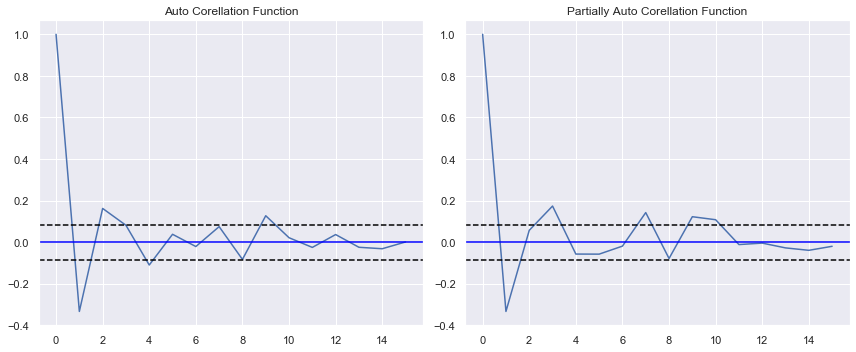

In [82]:
#plot PACF
rcParams['figure.figsize'] = 12,5
plt.subplot(121)
plt.plot(acf)
plt.axhline(y=0, linestyle='-', color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='black')
plt.title('Auto Corellation Function')
plt.tight_layout()

#plot ACF
rcParams['figure.figsize'] = 12,5
plt.subplot(122)
plt.plot(pacf)
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--', color='black')
plt.title('Partially Auto Corellation Function')
plt.tight_layout()

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Differencing_Decomposition_Details_ACF_PAC_lv1.jpg')

In order to find the p and q values from the above graphs, we need to check, where the graph cuts off the origin or drops to zero for the first time from the above graphs the p and q values are merely close to '1' where the graph cuts off the origin ( draw the line to x-axis) now we have p,d,q values. So now we can substitute in the ARIMA model and let's see the output.


 RMSE value on validation set:

0.022529031525401946


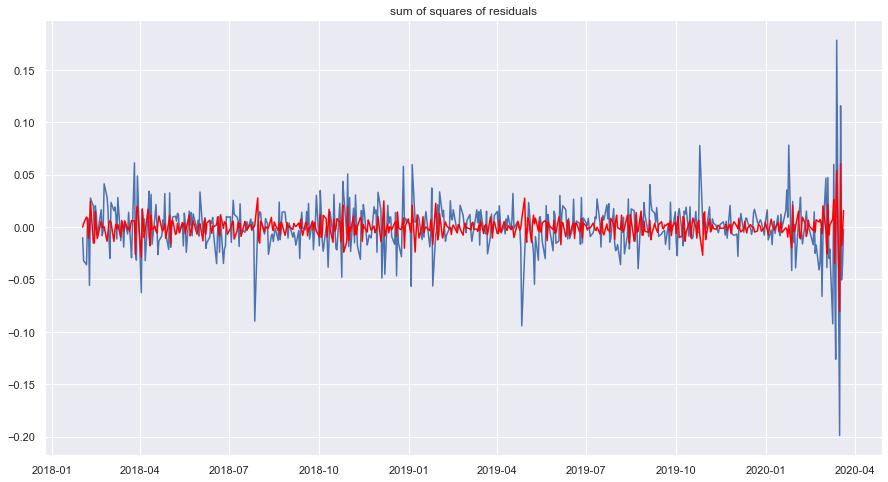

In [83]:
# less the RSS more effective the model is
#model = ARIMA(df_log, order=(2,1,0)) # RSS : 0.022996091864548398
#model = ARIMA(df_log, order=(2,1,2)) # RSS : 0.02253027681468738
#model = ARIMA(df_log, order=(3,1,2)) # RSS : 0.022530167581292705
model = ARIMA(df_log, order=(3,1,3)) # RSS : 0.022529031525401946  **
#model = ARIMA(df_log, order=(3,1,1)) # RSS : 0.022630374162916845
#model = ARIMA(df_log, order=(1,1,1)) # RSS : 0.023014868999682043
#model = ARIMA(df_log, order=(1,1,0)) # RSS : 0.023032746206601798
result_AR = model.fit(disp = 0)

rcParams['figure.figsize'] = 15,8
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")

# less the RSS more effective the model is
#print('RSS : %f' %sum((result_AR.fittedvalues - df_log_diff["close"])**2))

rms1 = np.sqrt(np.mean(np.power((np.array(result_AR.fittedvalues) - np.array(df_log_diff["close"]) ),2)))
print('\n RMSE value on validation set:\n')
print(rms1)

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Differencing_Decomposition_Details_ACFPAC_RMSE_lv1.jpg')

The lower the RSS value, the more effective the model is.

In [78]:
df_log.head()

,close
date,
2018-01-31,3.874113
2018-02-01,3.863883
2018-02-02,3.831897
2018-02-05,3.795939
2018-02-06,3.804660


In [79]:
df_log.tail()

,close
date,
2020-03-16,3.797958
2020-03-17,3.913622
2020-03-18,3.863043
2020-03-19,3.827336
2020-03-20,3.824939


#### 3.7 ARIMA Predictions

The following code helps us to forecast 'Close price' for the next 90 days.

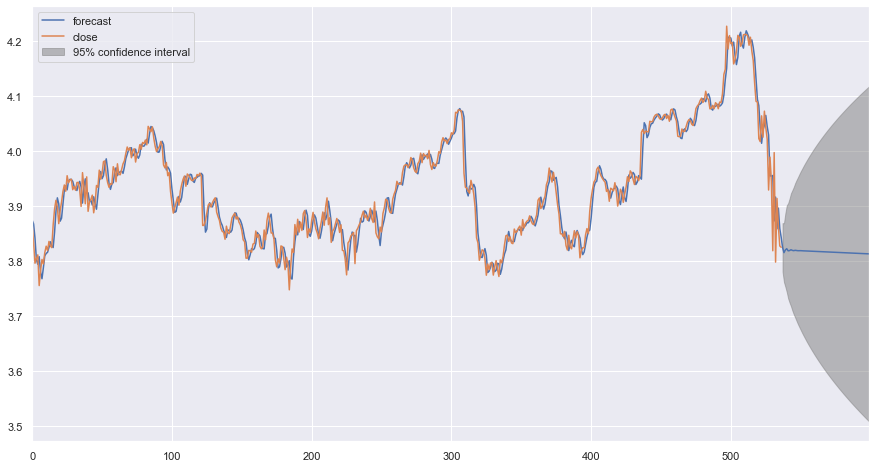

In [85]:
rcParams['figure.figsize'] = 15,8
result_AR.plot_predict(1, 600)
x = result_AR.forecast(steps=200)

plt.savefig('.\\images\\Close_Stock_Price_Seasonal_Differencing_Decomposition_Details_ARIMA_Adjust_lv1.jpg')

#### 3.8 Save data adjusted

In [87]:
# load data
df_log.to_csv('.\\data\\eod.data-intc-decompose.lv2.csv')